## Importing required libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [2]:
from tqdm import tqdm
import time
from collections import OrderedDict
import re
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Checking if CUDA is available

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Example Song (Input - Document)

In [4]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Bigram language model - Using Conditional Probabilities

#### Tokenization

In [5]:
# a function to remove all not-word characters in a word
def preprocess_string(s):
    # remove all non-word charecters except numbers and letters
    s = re.sub(r"[^\w\s]",'',s)
    # replace all runs of witespaces with no space
    s = re.sub(r"\s+",'',s)
    # replace digits with no space
    s = re.sub(r"\d",'',s)
    return s

print(f"Example Input Word:- 'Word2Vec'\nExample Output Word:- {preprocess_string('Word2Vec')}")

Example Input Word:- 'Word2Vec'
Example Output Word:- WordVec


In [6]:
# using the "word_tokenize" function from "nltk" library for tokenization
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [w.lower() for w in tokens if len(w) != 0 or not(w in string.punctuation)]

tokens=preprocess(song) # preserves the order
vocabulary = set(tokens)
print(f"Example 1st ten tokens:-\n{tokens[0:10]}")
print(f'Total no of tokens :-{len(tokens)}')
print(f'Total no of unique tokens :-{len(vocabulary)}')

Example 1st ten tokens:-
['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']
Total no of tokens :-385
Total no of unique tokens :-80


#### Calcualting the frequency distribution of tokens

In [7]:
# using the "FreqDist" function from "nltk" library to calculate the token frequecy
fdist = nltk.FreqDist(tokens)
display(fdist)

# total counts
print(f"Total word count:- {sum(fdist.values())}")
print(f"Total unique word count:- {len(list(fdist.keys()))} ")

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

Total word count:- 385
Total unique word count:- 80 


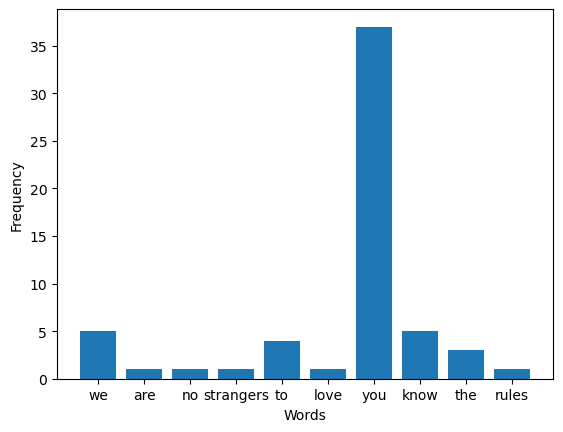

In [8]:
# a bar plot with the first ten token frequencies using the "pyplot" function from "matplotlib" library
plt.bar(list(fdist.keys())[0:10], list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

#### Creating bigrams

In [9]:
# creating consecutive pairs of tokens using the "bigrams" function from "nltk" library
bigrams = list(nltk.bigrams(tokens))
print(f'The first ten bigrmas:-\n{bigrams[:10]}')

The first ten bigrmas:-
[('we', 'are'), ('are', 'no'), ('no', 'strangers'), ('strangers', 'to'), ('to', 'love'), ('love', 'you'), ('you', 'know'), ('know', 'the'), ('the', 'rules'), ('rules', 'and')]


#### Calcutating the frequency distribution of bigrams

In [10]:
# using the "FreqDist" function from "nltk" library to calculate the bigram frequecy
freq_bigrams = nltk.FreqDist(nltk.bigrams(tokens))
display(freq_bigrams)

# total counts
print(f"Total bigram count:- {sum(freq_bigrams.values())}")
print(f"Total unique bigram count:- {len(list(freq_bigrams.keys()))} ")

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

Total bigram count:- 384
Total unique bigram count:- 119 


#### Calculating the conditional probabilities for the example token - "strangers"

In [11]:
word = 'strangers'
vocab_probabilities = {}
for next_word in vocabulary:
    vocab_probabilities[next_word] = freq_bigrams[(word, next_word)]/fdist[word]

vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x:x[1], reverse=True)

print("Top 4 more likely word to occur after 'strangers':-\n", vocab_probabilities[:4])

Top 4 more likely word to occur after 'strangers':-
 [('to', 1.0), ('we', 0.0), ('whats', 0.0), ('im', 0.0)]


#### A function for next word prediction using conditional probability of the next word given a sequence

In [12]:
def make_predictions(input_context_words, freq_grams, norm,vocabulary=vocabulary):
    vocab_probabilities = {}
    input_context_tokens = preprocess(input_context_words)

    # calculating the probabilities
    for next_word in vocabulary:
        temp = input_context_tokens.copy()
        temp.append(next_word) # adding the next word to the context

        #calculating the conditional probability
        vocab_probabilities[next_word] = freq_grams[tuple(temp)] / norm

    # sorting the probabilities
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x:x[1], reverse=True)

    return vocab_probabilities

print("Top 4 more likely word to occur after 'strangers':-\n", make_predictions('strangers', freq_bigrams, fdist['strangers'])[:4])

Top 4 more likely word to occur after 'strangers':-
 [('to', 1.0), ('we', 0.0), ('whats', 0.0), ('im', 0.0)]


#### Generating a song using the bigram model

In [13]:
my_song="we"
input_word = my_song
for i in range(100):
    next_word = make_predictions(input_word, freq_bigrams, fdist[input_word])[0][0]
    my_song += " "+ next_word
    input_word = next_word

print(my_song)

we both know the game and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na


## Language Models - Using Feedforward Neural Networks (FNNs)

#### Tokenization and building the vocabulary

In [14]:
# using the "get_tokenizer" function from "torchtext" library for tokenization
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(song)
print('No of tokens in the song:- ',len(tokens))

# an iterable to generate the vocabulary
tokenized_song = map(tokenizer, song.split())

# using the 'buid_vocab_from_iterator' function from 'torchtext' library
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])
vocab.set_default_index(vocab['<unk>']) # # This index will be returned when OOV token is queried
vocab_size = len(vocab)
print(f"Vocab Size:- {vocab_size}\n")

# printing the tokenized text and token indices of 1st 10 words of the song
song_first_10 = " ".join(song.split()[:10])
tokenized_text = tokenizer(song_first_10)
token_indices = vocab(tokenized_text)
print("First 10 word of the song:-\n",song_first_10,"\n")
print("Tokenized text:-\n",tokenized_text,"\n")
print("Token indices:-\n", token_indices)

No of tokens in the song:-  343
Vocab Size:- 79

First 10 word of the song:-
 We are no strangers to love You know the rules 

Tokenized text:-
 ['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules'] 

Token indices:-
 [21, 58, 70, 74, 25, 69, 2, 20, 31, 72]


#### Creating n-grams

In [15]:
CONTEXT_SIZE = 3
ngrams = [
    ([tokens[i-j-1] for j in range(CONTEXT_SIZE)], tokens[i])
    for i in range(CONTEXT_SIZE, len(tokens))
]

# printing the first 5 ngram
print("([context words list], target-word)\n")
print("([t-1,t-2,t-3]) t\n")
for ngram in ngrams[:5]: print(ngram)

([context words list], target-word)

([t-1,t-2,t-3]) t

(['no', 'are', 'we'], 'strangers')
(['strangers', 'no', 'are'], 'to')
(['to', 'strangers', 'no'], 'love')
(['love', 'to', 'strangers'], 'you')
(['you', 'love', 'to'], 'know')


#### Pre-processing pipline

In [45]:
# pipline to convert raw text into token indices using the "tokenizer" and "vocab" functions defined about
text_pipeline = lambda x: vocab(tokenizer(x))

# a pipline to get token given token index
index_to_token_pipeline = lambda x: vocab.get_itos()[x]


CONTEXT_SIZE=3
BATCH_SIZE=10
EMBEDDING_DIM = 10

# the collate function to process the batches from the dataloaders
def collate_batch(batch):
    batch_size = len(batch)
    context, target = [], []
    for i in range(CONTEXT_SIZE, batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))
    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

#### Creating dataloaders for ML model

In [47]:
BATCH_SIZE = 10
padding = BATCH_SIZE - len(tokens)%BATCH_SIZE # appending the beginning of the song to the end to get unifrom batches
tokens_paded = tokens + tokens[:padding]

# creating dataloaders using "DataLoader" function from "pytorch" library
dataloader = DataLoader(
    tokens_paded,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

#printing the data in the first batch
print("The data in the first batch:- \n")
context_tensors, target_tensors = next(iter(dataloader))
for context_tensor, target_tensor in zip(context_tensors, target_tensors):
    context_words = [index_to_token_pipeline(t) for t in context_tensor]
    target_word = index_to_token_pipeline(target_tensor)
    print("Contect Words:- {:<25} Target Word:- {}".format("["+", ".join(context_words)+"]", target_word))
print("\nContext tensors:- \n", context_tensors)
print("\nTarget tensor:- \n", target_tensors)

The data in the first batch:- 

Contect Words:- [no, are, we]             Target Word:- strangers
Contect Words:- [strangers, no, are]      Target Word:- to
Contect Words:- [to, strangers, no]       Target Word:- love
Contect Words:- [love, to, strangers]     Target Word:- you
Contect Words:- [you, love, to]           Target Word:- know
Contect Words:- [know, you, love]         Target Word:- the
Contect Words:- [the, know, you]          Target Word:- rules

Context tensors:- 
 tensor([[70, 58, 21],
        [74, 70, 58],
        [25, 74, 70],
        [69, 25, 74],
        [ 2, 69, 25],
        [20,  2, 69],
        [31, 20,  2]], device='cuda:0')

Target tensor:- 
 tensor([74, 25, 69,  2, 20, 31, 72], device='cuda:0')


#### Defining the Nural Network architecture

In [48]:
#a feed forward NN implemented using "nn.Embedding", "nn.Linear" and "nn.functional" functions from "pytorch" library

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(input) 
        embeds = torch.reshape(embeds, (-1, self.context_size*self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

In [49]:
# instantiating the model
EMBEDDING_DIM = 10
model = NGramLanguageModeler(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE).to(device)

#### Example of one forward pass

In [65]:
# getting the embeddings of the context_tensors
embedded_context_tensor = model.embeddings(context_tensors)
# reshaping the context tensors to (EMBEDDING_DIM * CONTEXT_SIZE) dimention
embedded_context_tensor_reshaped = torch.reshape(embedded_context_tensor, (-1,EMBEDDING_DIM * CONTEXT_SIZE))
# passing through the first linear layer and relu activation function
hidden_out = F.relu(model.linear1(embedded_context_tensor_reshaped))
# final layer output
nn_out = model.linear2(hidden_out)

print("Example forward pass of the first n_gram:\n")
print("Contect Words:- [no, are, we]             Target Word:- strangers\n")
print("Context tensors:-\ntensor([[70, 58, 21], device='cuda:0')\n")
print("Context tensor embeddings:-\n",embedded_context_tensor[0])
print("\nRe-shaped Context tensor embeddings:-\n", embedded_context_tensor_reshaped[0])
print("\nHidden layer output:-\n", hidden_out[0])
print("\nNural Network otuput:-\n", nn_out[0])



Example forwarf pass of the first n_gram:

Contect Words:- [no, are, we]             Target Word:- strangers

Context tensors:-
tensor([[70, 58, 21], device='cuda:0')

Context tensor embeddings:-
 tensor([[ 0.7307,  0.2689, -0.5523,  0.6353, -0.1539, -0.9658,  1.8148, -0.4063,
          0.1848, -0.7447],
        [-1.5605,  0.6927, -0.1327, -0.5621, -0.8637,  0.0152, -0.8167,  0.6541,
          1.0358, -0.3060],
        [-0.7393,  1.2424, -1.6711, -0.0937,  0.4314, -0.3739,  1.1067,  0.6083,
          1.8445,  0.3956]], device='cuda:0', grad_fn=<SelectBackward0>)

Re-shaped Context tensor embeddings:-
 tensor([ 0.7307,  0.2689, -0.5523,  0.6353, -0.1539, -0.9658,  1.8148, -0.4063,
         0.1848, -0.7447, -1.5605,  0.6927, -0.1327, -0.5621, -0.8637,  0.0152,
        -0.8167,  0.6541,  1.0358, -0.3060, -0.7393,  1.2424, -1.6711, -0.0937,
         0.4314, -0.3739,  1.1067,  0.6083,  1.8445,  0.3956], device='cuda:0',
       grad_fn=<SelectBackward0>)

Hidden layer output:-
 tensor([0.780

In [60]:
hidden_out

tensor([[7.8018e-01, 0.0000e+00, 4.7602e-01, 0.0000e+00, 0.0000e+00, 1.0192e-01,
         0.0000e+00, 1.6611e-01, 2.2375e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 8.2112e-01, 0.0000e+00, 3.9158e-01, 4.1796e-01, 0.0000e+00,
         0.0000e+00, 6.8455e-01, 0.0000e+00, 7.7695e-01, 0.0000e+00, 0.0000e+00,
         7.2423e-01, 8.4070e-02, 1.4121e-01, 9.3730e-03, 0.0000e+00, 4.4978e-01,
         2.1107e-01, 0.0000e+00, 1.3444e-02, 1.2113e-01, 3.6302e-01, 0.0000e+00,
         0.0000e+00, 5.1771e-01, 8.2186e-01, 0.0000e+00, 2.4057e-01, 0.0000e+00,
         0.0000e+00, 4.0876e-01, 0.0000e+00, 0.0000e+00, 7.4675e-01, 5.0383e-01,
         0.0000e+00, 7.5067e-01, 0.0000e+00, 6.0721e-01, 0.0000e+00, 2.8418e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2134e-01, 1.3320e+00, 2.7538e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3817e-01,
         0.0000e+00, 0.0000e+00, 1.5169e-03, 6.7883e-01, 0.0000e+00, 0.0000e+00,
         6.3068e-01, 9.0207e

In [62]:
nn_out

tensor([[ 4.4618e-02, -1.3616e-01,  1.0447e-01, -2.2080e-01,  2.5310e-01,
         -3.7086e-02,  8.7145e-02, -4.3516e-01,  7.9945e-02,  2.8792e-01,
          1.4256e-01,  9.3586e-02, -3.8550e-02,  1.0962e-01, -9.4654e-02,
          3.6891e-01,  1.4214e-01,  3.5071e-02,  2.5583e-01,  3.9744e-01,
         -6.5413e-02,  6.2235e-02, -2.3154e-01,  1.9187e-01,  5.0682e-01,
         -1.0110e-01, -5.3362e-02, -1.0859e-01,  1.8991e-01,  2.3025e-01,
         -1.1045e-01,  2.5889e-01, -1.3926e-01,  4.1655e-02,  2.9371e-03,
          2.4090e-01,  4.0829e-02, -2.1877e-01, -2.0251e-01,  5.2882e-01,
         -2.5396e-02, -2.0216e-01, -2.3425e-01,  1.5301e-01,  2.6718e-01,
          2.0572e-01,  2.3076e-03,  8.0562e-02, -4.1910e-02, -1.1471e-01,
         -2.6015e-01, -1.4003e-01, -1.5558e-01, -1.6776e-01, -1.6134e-01,
         -8.0091e-02,  4.7721e-02, -5.0264e-03,  2.4791e-01, -1.2284e-01,
          2.1086e-01,  1.0139e-01, -1.1285e-01,  1.2581e-01, -2.5513e-02,
          8.7956e-02,  5.2958e-02,  1.